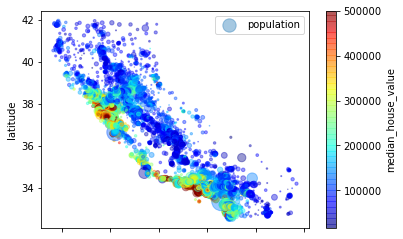

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import os
import tarfile

from six.moves import urllib

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml/master/" 
HOUSING_PATH = "datasets/housing" 
HOUSING_URL = DOWNLOAD_ROOT + HOUSING_PATH + "/housing.tgz" 

def fetch_housing_data(housing_url = HOUSING_URL, housing_path = HOUSING_PATH): 
    if not os.path.isdir(housing_path): 
        os.makedirs(housing_path) 
    
    tgz_path = os.path.join(housing_path, "housing.tgz") 
    urllib.request.urlretrieve(housing_url, tgz_path) 
    housing_tgz = tarfile.open(tgz_path) 
    housing_tgz.extractall(path = housing_path) 
    housing_tgz.close()
    
fetch_housing_data()

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

housing = load_housing_data()
#housing.hist(bins=50, figsize=(20, 15))
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"] / 100, label="population", 
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar = True)
plt.legend()

In [2]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688075
total_rooms           0.134153
housing_median_age    0.105623
households            0.065843
total_bedrooms        0.049686
population           -0.024650
longitude            -0.045967
latitude             -0.144160
Name: median_house_value, dtype: float64

In [3]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
#scatter_matrix(housing[attributes], figsize=(12,8))

In [4]:
housing["rooms_per_household"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["population_per_household"] = housing["population"] / housing["households"]

from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size=0.2, random_state=42)

housing["income_cat"] = np.ceil(housing["median_income"] / 1.5)
housing["income_cat"].where(housing["income_cat"] < 5, 5.0, inplace=True)

from sklearn.model_selection import StratifiedShuffleSplit
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)

strat_train_set = ""
strat_test_set = ""
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [5]:
housing = strat_train_set.drop("median_house_value", axis=1)
housing_labels = strat_train_set["median_house_value"].copy()
#print(housing_labels)
#print(housing.dropna(subset=["total_bedrooms"]))
#print(housing.drop("total_bedrooms", axis=1))
median = housing["total_bedrooms"].median()
#print(median)
#housing["total_bedrooms"].fillna(median)
#print(housing)

from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

housing_num = housing.drop("ocean_proximity", axis=1)
#print(housing_num)
#imputer.fit(housing_num)
#print(imputer.statistics_)
#print(housing_num.median().values)
#X = imputer.transform(housing_num)
#print(housing_num.columns)
#housing_tr = pd.DataFrame(X, columns=housing_num.columns)
#print(housing_tr)


In [6]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
housing_cat = housing["ocean_proximity"]
housing_cat_encoded = encoder.fit_transform(housing_cat)
#housing_cat_encoded
#print(encoder.classes_)

from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
housing_cat_1hot = encoder.fit_transform(housing_cat_encoded.reshape(-1,1))
#print(housing_cat_1hot.toarray())
#print(housing_cat_1hot)

from sklearn.preprocessing import LabelBinarizer
encoder = LabelBinarizer(sparse_output=True)
housing_cat_1hot = encoder.fit_transform(housing_cat)
#print(housing_cat_1hot)

In [7]:
from sklearn.base import BaseEstimator, TransformerMixin

rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6
#print(rooms_ix)

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True):
        self.add_bedrooms_per_room = add_bedrooms_per_room
        
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
#print(attr_adder)
housing_extra_attribs = attr_adder.transform(housing.values)
#print(housing.values)
print(housing_extra_attribs)

[[-121.89 37.29 38.0 ..., 2.0 4.625368731563422 2.094395280235988]
 [-121.93 37.05 14.0 ..., 5.0 6.008849557522124 2.7079646017699117]
 [-117.2 32.77 31.0 ..., 2.0 4.225108225108225 2.0259740259740258]
 ..., 
 [-116.4 34.09 9.0 ..., 3.0 6.34640522875817 2.742483660130719]
 [-118.01 33.82 31.0 ..., 3.0 5.50561797752809 3.808988764044944]
 [-122.45 37.77 52.0 ..., 3.0 4.843505477308295 1.9859154929577465]]


In [8]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler())
])

housing_num_tr = num_pipeline.fit_transform(housing_num)
#print(bedrooms_ix, rooms_ix)
print(housing_num_tr)

[[-1.15604281  0.77194962  0.74333089 ..., -0.31205452 -0.08649871
   0.15531753]
 [-1.17602483  0.6596948  -1.1653172  ...,  0.21768338 -0.03353391
  -0.83628902]
 [ 1.18684903 -1.34218285  0.18664186 ..., -0.46531516 -0.09240499
   0.4222004 ]
 ..., 
 [ 1.58648943 -0.72478134 -1.56295222 ...,  0.3469342  -0.03055414
  -0.52177644]
 [ 0.78221312 -0.85106801  0.18664186 ...,  0.02499488  0.06150916
  -0.30340741]
 [-1.43579109  0.99645926  1.85670895 ..., -0.22852947 -0.09586294
   0.10180567]]


In [14]:
from sklearn.pipeline import FeatureUnion

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values
    

num_attribs = list(housing_num)
#print(num_attribs)
cat_attribs = ["ocean_proximity"]

num_pipeline = Pipeline([
    ('selector', DataFrameSelector(num_attribs)),
    ('imputer', Imputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder()),
    ('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
    ('selector', DataFrameSelector(cat_attribs)),
    ('label_binarizer', LabelBinarizer()),
])

full_pipeline = FeatureUnion(transformer_list=[
    ("num_pipeline", num_pipeline),
    ("cat_pipeline", cat_pipeline),
])

housing_prepared = full_pipeline.fit_transform(housing)
print(housing_prepared)

[[-1.15604281  0.77194962  0.74333089 ...,  0.          0.          0.        ]
 [-1.17602483  0.6596948  -1.1653172  ...,  0.          0.          0.        ]
 [ 1.18684903 -1.34218285  0.18664186 ...,  0.          0.          1.        ]
 ..., 
 [ 1.58648943 -0.72478134 -1.56295222 ...,  0.          0.          0.        ]
 [ 0.78221312 -0.85106801  0.18664186 ...,  0.          0.          0.        ]
 [-1.43579109  0.99645926  1.85670895 ...,  0.          1.          0.        ]]


In [34]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)
#print(some_labels)
#print(some_data_prepared)
#print(lin_reg.predict(some_data_prepared))
#print(list(some_labels))


from sklearn.metrics import mean_squared_error
housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
#print(lin_mse, lin_rmse)


from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()
tree_reg.fit(housing_prepared, housing_labels)

housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)

#print(tree_mse, tree_rmse)


from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, housing_prepared, housing_labels, 
                        scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.sqrt(-scores)

#print(scores)

def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())
    

display_scores(rmse_scores)


lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                            scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)



from sklearn.ensemble import RandomForestRegressor
forest_reg = RandomForestRegressor()
forest_reg.fit(housing_prepared, housing_labels)
forest_scores = cross_val_score(forest_reg, housing_prepared, housing_labels,
                               scoring="neg_mean_squared_error", cv=10)
forest_rmse_scores = np.sqrt(-forest_scores)
display_scores(forest_rmse_scores)






Scores: [ 69981.15763209  67029.55812198  71582.12847363  70411.4358522
  70801.86429957  73864.66180877  70248.66153286  69055.27039988
  75064.94763105  69841.76138934]
Mean: 70788.1447141
Standard deviation: 2179.36336664
Scores: [ 66140.5574445   66402.64250448  67308.08567538  73980.14151657
  67666.27878335  70758.72248018  63820.26082748  67347.49168296
  70423.45351656  67291.28882149]
Mean: 68113.8923253
Standard deviation: 2722.37957801
Scores: [ 52009.98016757  49720.54363269  51877.000023    53470.40551375
  52504.0145978   55524.38531258  52544.1275495   50151.42972121
  55348.29467858  51823.86450046]
Mean: 52497.4045697
Standard deviation: 1803.60305014
